In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
# regular expression pattern used to filter out anything between < >
# Non predictive speaker information in english is always in between those two symbols

pattern = r'<(!?).*>'

# Max length of language transcription
# Ensure each language has similar amount of representation (Balanced Dataset)
MAX_LENGTH_TRANSCRIPTION = 150000

In [3]:

labels = { 
          1.0:'English', 
          2.0: 'Ga',
          3.0: 'Twi', 
          4.0: 'Ewe',
         
          }

# Map language to language code and file name

language_codes_files = {
    'English': ['en', '/ep-00-01-17.txt'], 
    'Ga': ['ga', '/ga.txt'], 
    'Twi': ['twi', '/twi.txt'],
    'Ewe': ['ewe','/ewe.txt'],
    
}

# These languages need multiple files combined to get a transcription of length
# >= MAX_LENGTH_TRANSCRIPTION
limited_raw_text = ['English', 'Ga', 'Twi', 'Ewe']

In [4]:
# Helper Functions

def combine_text_files(language_code, language):
   
    '''
    Goal: Certain languages do not have a single file of length >= MAX_LENGTH_TRANSCRIPTION
          This function will combine these files for this sort of language into one language
          transcription, and then write the transcription to a single file.
    
    @param: (string) language_code is the 2 character code of the language
    @param: (string) language is the English name of the language         
    '''    
    
    file_name_list = os.listdir('language_data/txt/' + language_code + '/')
    language_transcription = ''
    for file_name in file_name_list:
        if(len(language_transcription) >= MAX_LENGTH_TRANSCRIPTION):
            break;
        path = os.getcwd() + '/language_data/txt/' + language_code + '/' + file_name
        with open(path) as f:
            contents = f.read()
            language_transcription += contents
    
    write_path = os.getcwd() + '/language_data/txt/' + language_code + '/' + language + '.txt'
    with open(write_path, 'w') as f:
        f.write(language_transcription)

def read_languages_data(path):
    '''
    Goal: Read language data from file path into a list containing one massive string
    
    @param path: (string) file path pointing to the raw natural language text
                 Original file data source found here: http://www.statmt.org/europarl/
    @return language_transcription: (list) language_transcription is a list of one string containing the whole text
    '''
    with open(path) as f:
        language_transcription = f.read()
        language_transcription = language_transcription[:MAX_LENGTH_TRANSCRIPTION]
    return language_transcription

def clean_sentences(sentences):
    '''
    Goal: Filter out non predictive text about speaker using regular expression pattern
    
    @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                       Note: The raw language_transcription should be tokenized by sentence prior
                       to being passed into this function.
    '''
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(pattern,'',sentence)

def combine_language_data(sentences, language_index):
    '''
    Goal: Transform list of string sentences into np.array, and stack horizontally with an np.array containing 
          the sentence's language_index, which maps to the sentence language. Essentially, apply label to data.
    
    @param sentences: (list) sentences is a list of strings that has had speaker information filtered out
    @param language_index: (float) language_index is a float that maps to a specific language in the labels dictionary
    @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
    '''
    sentences = np.array(sentences)
    sentences = sentences.reshape(sentences.shape[0],1)
    target = np.zeros((sentences.shape[0],1))
    target += language_index
    language_data = np.hstack((sentences, target))
    return language_data

def test_languages(X_test, true_values, predictions):
    '''
    Goal: Visualize the ~99% prediction accuracy by comparing,
        1. natural language sentence
        2. predicted natural language
        3. true natural language
    
    @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
    @param true_values: (np.array) true_values is a np.array containing the true language_index labels
    @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels
    '''
    
    true_values = np.array(true_values)
    
    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

def shuffle_rows(languages):
    '''
    Goal: Shuffle rows of 2D np.array with language data
    
    @param languages: un-mixed 2D np.array with language sentence features, and language_index labels
    @return shuffled_languages: shuffled by row, 2D np.array 
    '''
    
    index = np.arange(0, len(languages))
    np.random.shuffle(index)
    shuffled_languages = languages[index,:]

    return shuffled_languages
    
def preproccess_raw_data(file_paths):
    '''
    Goal: Run all data preprocessing helper functions
    
    @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                        points to a raw text file from the European Parliament Proceedings.
    @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                        The first dimension has the a sentence, and the second dimension
                        has the language_index label, that maps to the language.
    '''
    
    # Combine transcriptions of subset languages into a single file to ensure
    # each file will have len >= MAX_LENGTH_TRANSCRIPTION
    language_codes_files_subset = dict( (key, language_codes_files[key] ) for key in limited_raw_text if key in language_codes_files )
    for language in language_codes_files_subset.keys():
        combine_text_files(language_codes_files_subset[language][0], language)
    
    # Read all raw text data from file paths
    language_transcriptions = [ read_languages_data(path) for path in file_paths ]
    
    # tokenize each raw text string into a list of sentences
    for i, language_transcription in enumerate(language_transcriptions):
        language_transcriptions[i] = sent_tokenize(language_transcription)
    
    # Remove information about speakers using a regular expression pattern
    for sentences in language_transcriptions:
        clean_sentences(sentences)
    
    # Combine each language with its language_index
    languages = [ combine_language_data(sentences,i+1) for i,sentences in enumerate(language_transcriptions) ]
    
    # Vertically stack all data into one 2D np.array
    languages =  np.vstack((languages))
    
    # Shuffle languages by row
    languages = shuffle_rows(languages)
    
    return languages
    

In [5]:
# Get all file paths

file_paths = [ os.getcwd() + '/language_data/txt/' + language_codes_files[language][0] + language_codes_files[language][1] for language in language_codes_files ]
# file_paths
# Preprocess all raw text into a form suitable for TfidfVectorizer
languages = preproccess_raw_data(file_paths)
languages

array([['Bɔ fɛɛ bɔ ni ji lɛ, maŋnyɛ lɛ bashɛ Yerusalem “kɛ asafo babaoo diɛŋtsɛ, kɛ yomai ni tere tsofai-kɛ-ŋmai kɛ shika babaoo diɛŋtsɛ kɛ tɛi ni jara wa.”\n* Taakɛ Elia ji yɛ be mli ni ejoɔ Maŋnyɛ Izebel naa foi lɛ, shwɛɛnii ni afɔ amɛ mu, ni sheɔ gbeyei lɛ susu akɛ amɛ nitsumɔ lɛ eba naagbee yɛ Jeŋ Ta I be lɛ mli.',
        '2.0'],
       ['(b) Kɛ́ gbɔmɛi nu he akɛ shihilɛi gbohii yeɔ odase akɛ Nyɔŋmɔ ko bɛ lɛ, te ooofee tɛŋŋ obɔ mɔdɛŋ koni okɛ amɛ asusu sane he lɛ?',
        '2.0'],
       ['Mele dzidzɔ kpɔm elabena togbɔ be metsi hã la, megakpɔtɔ nye dɔwɔnu na Yehowa.”\nNe nenemae la, àte ŋu abia nya sia atsɔ adze dzeɖoɖoa gɔme: “Ho nenie nèsusu be ele be ƒome ƒe tawo nakpɔ ɣleti sia ɣleti be woƒe ƒomewo nakpɔ dzidzɔ?”\nDzi dzɔm esi mese le ɖokuinye me be mena dzi le Yehowa dzɔm.',
        '4.0'],
       ...,
       ['Yesu kɔlɔ blodoi lɛ kɛ loi lɛ, ni esɔle, ni no sɛɛ lɛ, ekɛhã ekaselɔi lɛ, ni amɛ hu amɛkɛhã mɛi lɛ\nKɛkɛ ni gbi ko, beni Yesu nyiɛ yɛ Galilea Ŋshɔ lɛ naa lɛ, ena Pet

In [6]:
df_languages = pd.DataFrame(languages)
df_languages.columns = ['natural language', 'language index']
df_languages['language index'] = df_languages['language index'].apply(float)
df_languages['language'] = df_languages['language index'].map(labels)
print(df_languages.isnull().any())
display(df_languages.head(10))

natural language    False
language index      False
language            False
dtype: bool


,natural language,language index,language
0,"Bɔ fɛɛ bɔ ni ji lɛ, maŋnyɛ lɛ bashɛ Yerusalem ...",2.0,Ga
1,(b) Kɛ́ gbɔmɛi nu he akɛ shihilɛi gbohii yeɔ o...,2.0,Ga
2,"Mele dzidzɔ kpɔm elabena togbɔ be metsi hã la,...",4.0,Ewe
3,"Momma me mmuae, na me nso mɛka tumi ko a mede ...",3.0,Twi
4,"Ákɛ nɔkwɛmɔnɔ lɛ, nyɛmi yoo ko ní kɛtsɔ opires...",2.0,Ga
5,Dzidzɔ nye nudzedziname vavãtɔ ƒe nɔnɔme si ɖo...,4.0,Ewe
6,Nusianu si Mawu wɔ la ɖe eƒe lɔlɔ̃ fia.,4.0,Ewe
7,"151 17 Fa Onyamesom Pa Di Dwuma Wɔ Fie\nNanso,...",3.0,Twi
8,Nusia nye taɖui na Dada ŋutɔ menye ɖe Papa ƒe ...,4.0,Ewe
9,Subsidies are not enough to ensure development...,1.0,English


In [7]:
df_languages.shape

(4286, 3)

In [8]:
# Split data into raw features and labels

language_features = df_languages['natural language']
language_targets = df_languages['language index']

In [9]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{1.0: 890, 2.0: 1085, 3.0: 1234, 4.0: 1077}

In [10]:
# Split data into training and test set
# Train on 70% of data, Test on remaining 30%

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [11]:

# Make Machine Learning Pipeline with TfidfVectorizer and MultinomialNB

tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [12]:

# Train model with pipeline classifier

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [13]:

# Make predictions on unseen test data with trained classifier

predictions = text_clf.predict(X_test)

In [14]:

# Measure accuracy

accuracy_score(y_test,predictions)

0.9821150855365475

In [15]:

# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores = cross_val_score(text_clf, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores.mean()))

Mean cross-validation accuracy: 0.9789986614003233


In [16]:
# Model persistence
output_model_file = 'model.pkl'

# Save the model
with open(output_model_file, 'wb') as f:
    pickle.dump(text_clf, f)

In [17]:
print(classification_report(y_test, predictions, target_names=labels.values()))

              precision    recall  f1-score   support

     English       1.00      1.00      1.00       278
          Ga       1.00      0.95      0.98       310
         Twi       0.98      0.98      0.98       375
         Ewe       0.95      1.00      0.97       323

    accuracy                           0.98      1286
   macro avg       0.98      0.98      0.98      1286
weighted avg       0.98      0.98      0.98      1286



[Text(0, 0.5, 'English'),
 Text(0, 1.5, 'Ga'),
 Text(0, 2.5, 'Twi'),
 Text(0, 3.5, 'Ewe')]

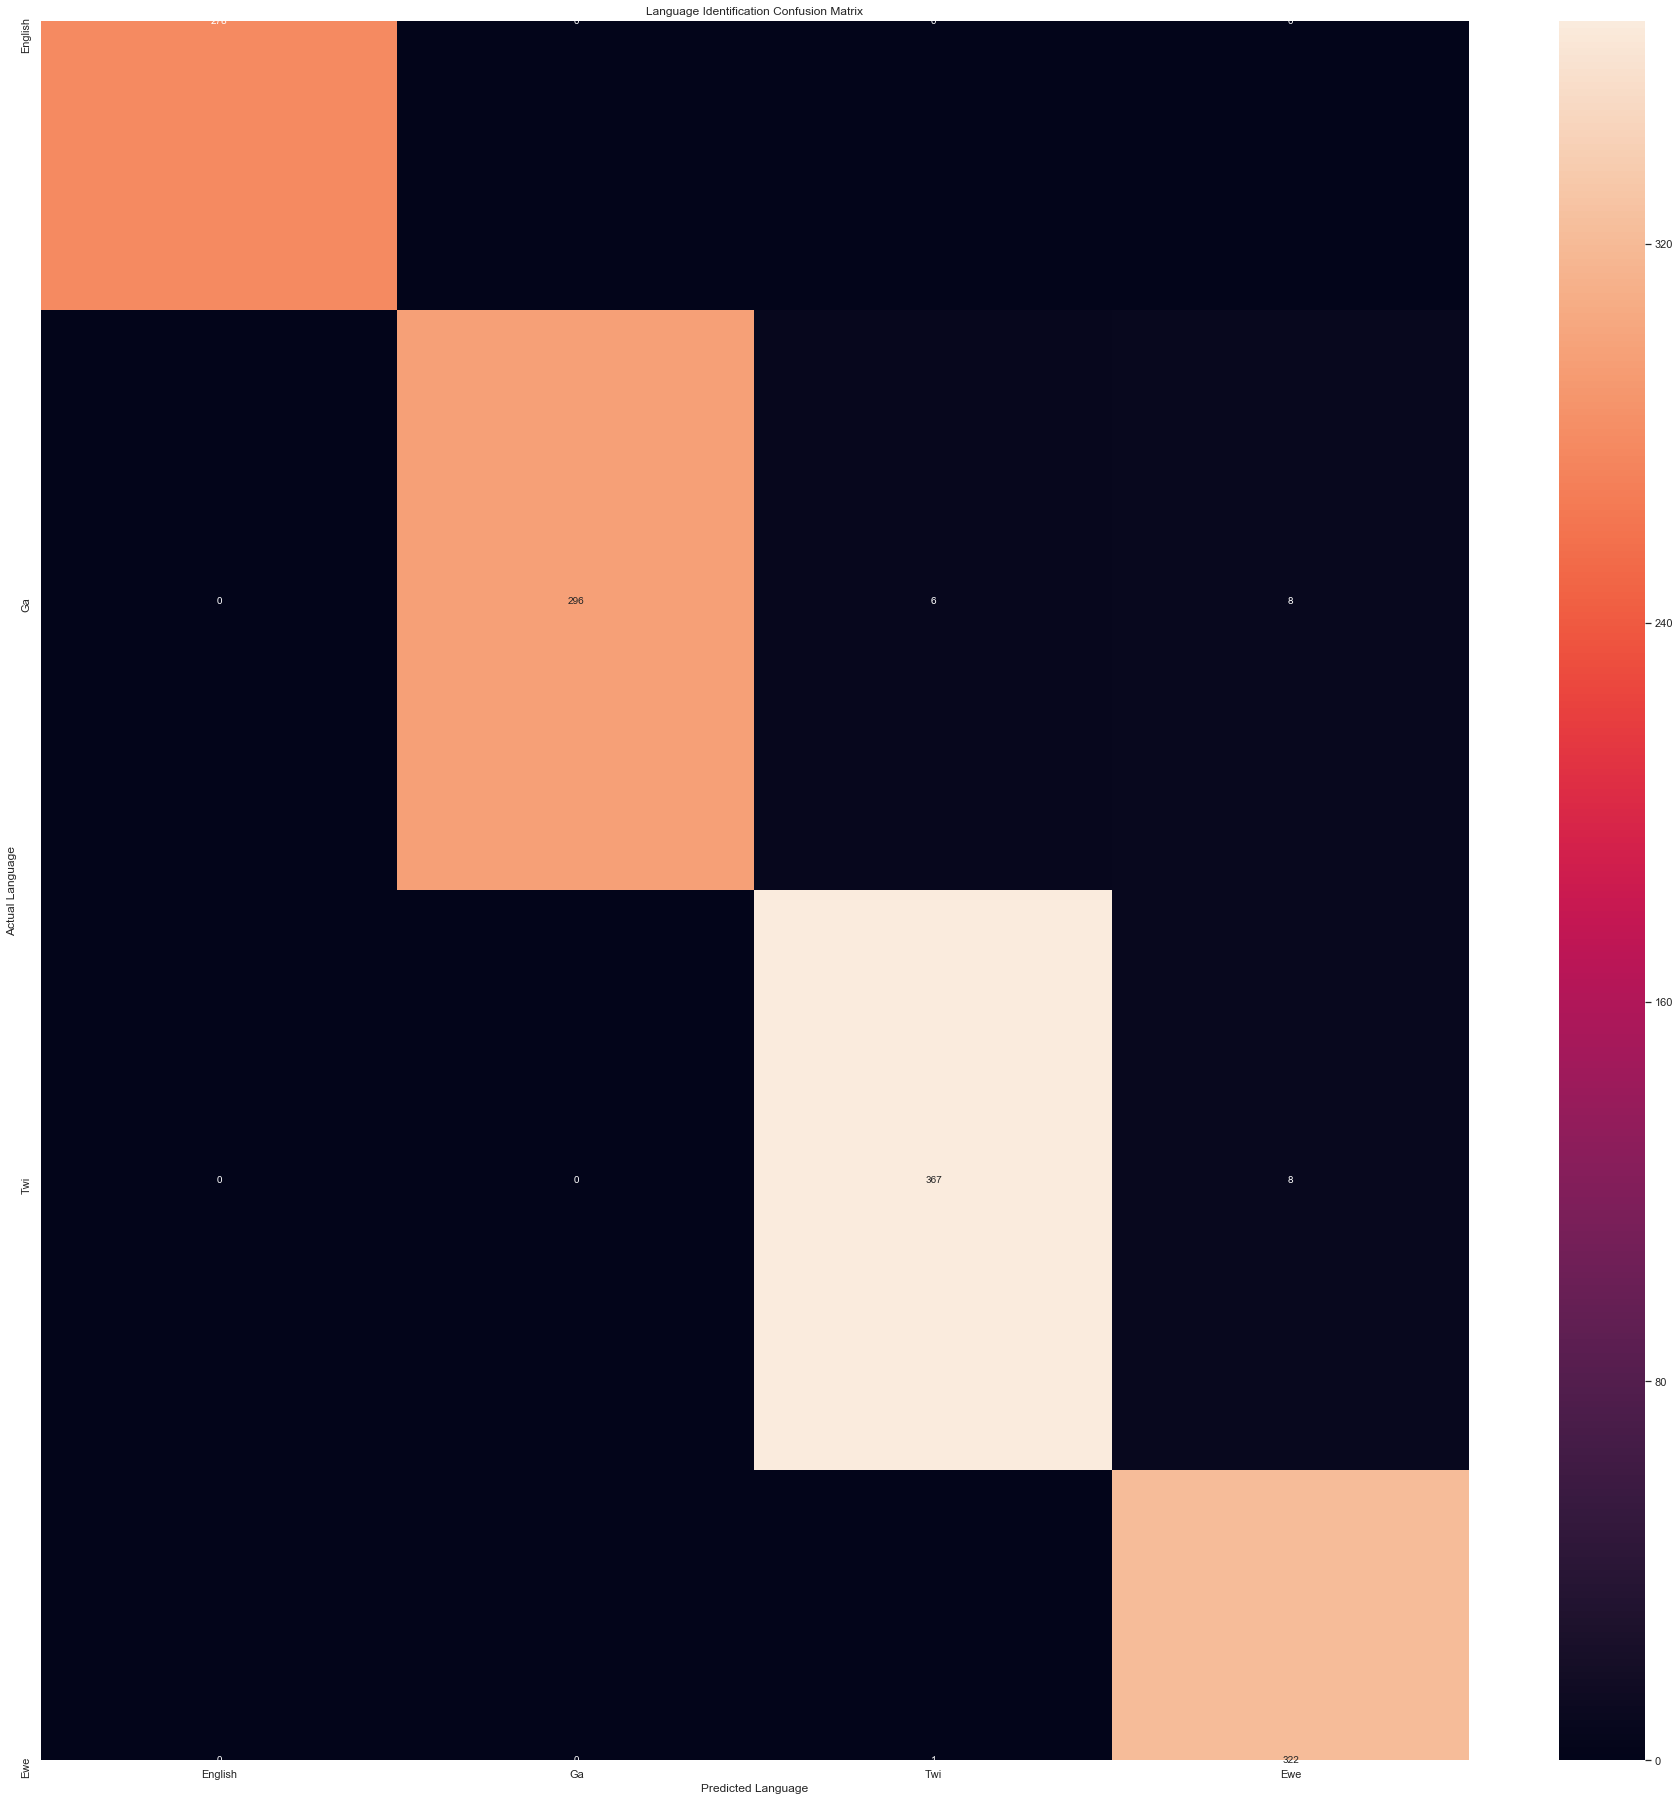

In [18]:
language_names = list(language_codes_files.keys())
plt.figure(figsize=(32, 32))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(labels.values())
ax.set_yticklabels(labels.values())

In [19]:
plt.show()

In [20]:
# Visualize Performance

test_languages(X_test, y_test, predictions)

Prediction: Ewe
Actual Language: Ewe
Input Sentence: 
▪ Gbɔdɔdɔ to nume “kpɔa ame ta.”
9.


Prediction: Twi
Actual Language: Twi
Input Sentence: 
Eric: Aah mahu.


Prediction: English
Actual Language: English
Input Sentence: 

I would like to ask the Vice-President if she is in a position to tell us today what the state of play is with regard to the efforts towards harmonisation being made by these two organisations, and whether the EU is in a position to hasten these harmonisation efforts, in accordance with principles that are as simple as possible.


Prediction: Twi
Actual Language: Twi
Input Sentence: 
Enti bere a yegyee tebea no toom no, yɛyɛɛ nhyehyɛe fii Ghana gyaw yɛn nnamfonom a wɔwɔ hɔ no san kɔɔ Canada wɔ June 1975 mu.


Prediction: Twi
Actual Language: Twi
Input Sentence: 
Ahosohyira ne asubɔ yɛ ade a ɛho hia sɛ Kristofo yɛ na ama wɔanya Yehowa nhyira.


Prediction: Ga
Actual Language: Ga
Input Sentence: 
Tso lɛ kwɛ̃ jenamɔ kɛ jetsɛremɔ ni eha Yona, ni eyafee asese yɛ Niniv

In [28]:
pred = text_clf.predict(['nyame ayɛ'])
labels[float(pred[0])]

'Twi'

In [22]:
# Load the model
with open(output_model_file, 'rb') as f:
    text_clf_file = pickle.load(f)

In [23]:
pred = text_clf_file.predict(['Nyɛfea Nyɛ Weku Nikasemɔ lɛ Daa.'])
labels[float(pred[0])]

'Ga'